In [1]:
import sys
sys.path.append('..')

from utils import *
from model import *
from tqdm.auto import trange

import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
# camera = ThinLenCamera(0.1, focal_length=3.5e-3 ,pixel_size=1.4e-5)
camera = ThinLenCamera(1.2, focal_length=17e-3, pixel_size=1.2e-5)

In [3]:
data_path = '/mnt/cfs/sihaozhe/data/dfd_datasets/dfd_indoor/dfd_dataset_indoor_N8'
split = 'train'
rgb_path = os.path.join(data_path, 'rgb', split)
dpt_path = os.path.join(data_path, 'depth', split)
fs_path = os.path.join(data_path, 'fs5')
if not os.path.exists(fs_path):
    os.mkdir(fs_path)
fs_path = os.path.join(fs_path, split)
device = 0
use_cuda = True

In [4]:
if not os.path.exists(fs_path):
    os.mkdir(fs_path)

In [5]:
render = GaussPSF(7)
render.cuda()

GaussPSF()

In [6]:
imglist = [f for f in os.listdir(rgb_path) if os.path.isfile(os.path.join(rgb_path, f))]
imglist.sort()
dptlist = [f for f in os.listdir(dpt_path) if os.path.isfile(os.path.join(dpt_path, f))]
dptlist.sort()

In [7]:
# fd_list = [2, 3, 4.5, 5, 7]
fd_list = [1, 1.5, 2.5, 4, 6]
# fd_list = np.linspace(1, 9, 100)

In [8]:
for idx in trange(len(imglist)):
    exp_aif = cv2.resize(cv2.imread(os.path.join(rgb_path, imglist[idx]))[:, :, :640], (640//2, 432//2))/255.
    # exp_aif = cv2.imread(os.path.join(rgb_path, imglist[idx]))/255.
    exp_dpt = Image.open(os.path.join(dpt_path, dptlist[idx]))
    exp_dpt = np.asarray(exp_dpt, dtype=np.float32)[:, :640]
    exp_dpt = np.clip(np.asarray(exp_dpt, dtype=np.float32) / 1e3, 0.1, 10)
    exp_dpt = cv2.resize(exp_dpt, (640//2, 432//2))
    
    dpt = torch.from_numpy(exp_dpt).unsqueeze(0)
    aif = torch.from_numpy(exp_aif.transpose(2, 0, 1)).type(torch.float32).contiguous()
    
    for i, fd in enumerate(fd_list):
        defocus = camera.getCoC(dpt, fd).type(torch.float32)
        fs = render(aif.unsqueeze(0).cuda(), defocus.cuda())
        im = fs.cpu().numpy()[0].transpose(1, 2, 0) * 255.
        fn = f'{imglist[idx][:-4]}_{str(i).zfill(4)}.png'
        # cv2.imwrite(os.path.join(fs_path, fn), im.astype(np.uint8))

  0%|          | 0/81 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/haozhesi/anaconda3/envs/defocus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_19485/4010715750.py", line 14, in <module>
    fs = render(aif.unsqueeze(0).cuda(), defocus.cuda())
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/haozhesi/anaconda3/envs/defocus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/haozhesi/anaconda3/envs/defocus/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of

TypeError: object of type 'NoneType' has no len()

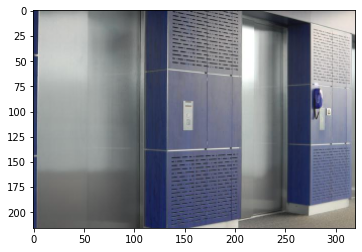

In [80]:
plt.imshow(exp_aif)

In [102]:
depth_near_far = []
depth_var = []
for idx in trange(len(imglist)):
    exp_dpt = Image.open(os.path.join(dpt_path, dptlist[idx]))
    exp_dpt = np.asarray(exp_dpt, dtype=np.float32)[:, :640]
    exp_dpt = np.clip(np.asarray(exp_dpt, dtype=np.float32) / 1e3, 0.1, 10)
    exp_dpt = cv2.resize(exp_dpt, (640//2, 432//2))
    
    depth_near_far.append((np.min(exp_dpt), np.max(exp_dpt)))
    depth_var.append((np.var(exp_dpt)))    

  0%|          | 0/81 [00:00<?, ?it/s]

In [103]:
examplar = [0, 12, 14, 15, 17, 18, 19,  2, 20, 22, 23, 24, 25, 27, 29, 30, 31,
       32, 33, 34, 35, 36, 38, 39, 40, 42, 44, 45, 46, 53, 55, 56, 58, 59,
        6, 60, 61, 62, 63, 64, 65, 66, 69,  7, 71, 73, 74, 79,  8]
len(examplar)

49

In [104]:
bad = [1, 10, 11, 13, 16, 21, 26, 28,  3, 37,  4, 47, 48, 49,  5, 50, 52,
       54, 57, 67, 68, 75,  9]
len(bad)

23

In [105]:
for i in examplar:
    print(i, depth_near_far[i])

0 (0.773, 3.553)
12 (0.5605, 5.433)
14 (1.5025, 3.733)
15 (0.743, 3.8014998)
17 (0.67925, 3.568)
18 (0.519, 2.47225)
19 (0.51524997, 3.4855)
2 (0.246, 3.894)
20 (0.5545, 3.52175)
22 (1.392, 9.471251)
23 (0.628, 5.458)
24 (1.259, 8.763)
25 (1.5910001, 8.775)
27 (1.0955, 4.308)
29 (0.482, 5.87675)
30 (0.68149996, 3.746)
31 (0.6445, 3.873)
32 (0.38625002, 6.295)
33 (0.53375, 2.65375)
34 (0.64199996, 2.7962499)
35 (0.56725, 2.843)
36 (0.495, 3.29)
38 (0.582, 4.274)
39 (0.608, 4.171)
40 (0.5935, 3.644)
42 (0.3355, 5.524)
44 (0.41375, 3.624)
45 (1.2969999, 3.588)
46 (0.295, 5.152)
53 (0.512, 3.324)
55 (1.0925, 3.547)
56 (1.3175, 3.622)
58 (0.55, 2.991)
59 (0.36025, 1.706)
6 (0.93399996, 4.673)
60 (0.524, 2.4559999)
61 (0.55, 4.358)
62 (0.31325, 3.925)
63 (0.305, 3.873)
64 (0.479, 4.449)
65 (0.852, 4.604)
66 (0.938, 3.84775)
69 (0.334, 3.7)
7 (1.031, 8.372)
71 (0.462, 3.468)
73 (1.59875, 9.32125)
74 (2.2827501, 3.3305001)
79 (2.55225, 6.324)
8 (1.3657501, 8.144)


In [106]:
for i in bad:
    print(i, depth_near_far[i])

1 (0.47974998, 3.275)
10 (0.36125, 2.933)
11 (0.45575, 4.298)
13 (1.1215, 8.59775)
16 (0.61475, 3.92)
21 (0.77825, 9.832)
26 (1.147, 4.4437494)
28 (0.3855, 5.137)
3 (0.644, 4.177)
37 (0.7475, 4.055)
4 (0.46600002, 4.6695004)
47 (0.61675, 2.812)
48 (0.43775, 1.629)
49 (0.5365, 4.71875)
5 (0.389, 4.5004997)
50 (1.776, 6.6345)
52 (0.50450003, 2.643)
54 (0.512, 3.333)
57 (0.85525, 2.316)
67 (0.308, 3.3747501)
68 (0.317, 3.3325)
75 (1.914, 4.947)
9 (0.364, 5.081)


In [29]:
depth_near_far[1]

(0.47974998, 3.275)

In [27]:
candidate = []
for idx, (near, far) in enumerate(depth_near_far):
    if near < 1.1 and far > 3.5 and far < 7:
        candidate.append(idx)
len(candidate)

39

In [28]:
np.array(candidate)

array([ 0,  2,  3,  4,  5,  6,  9, 11, 12, 15, 16, 17, 20, 23, 27, 28, 29,
       30, 31, 32, 37, 38, 39, 40, 41, 42, 43, 44, 46, 49, 51, 55, 61, 62,
       63, 64, 65, 66, 69])

good: 76 0 7 2 4
bad: 74 

### Example

In [12]:
idx = 28
exp_aif = cv2.resize(cv2.imread(os.path.join(rgb_path, imglist[idx])), (640//2, 432//2))/255.
# exp_aif = cv2.imread(os.path.join(rgb_path, imglist[idx]))/255.
# exp_dpt = cv2.imread(os.path.join(dpt_path, imglist[idx]))[:, :, 0] / 1000.
exp_dpt = Image.open(os.path.join(dpt_path, dptlist[idx]))
exp_dpt = np.clip(np.asarray(exp_dpt, dtype=np.float32) / 1e3, 0.1, 10)
exp_dpt = np.expand_dims(exp_dpt, axis=2)
# exp_dpt = exp_dpt / exp_dpt.max() 
# exp_dpt = exp_dpt * 9.9 + 0.1
exp_dpt = cv2.resize(exp_dpt, (640//2, 432//2)) 

In [13]:
dpt = torch.from_numpy(exp_dpt).unsqueeze(0)
aif = torch.from_numpy(exp_aif.transpose(2, 0, 1)).type(torch.float32).contiguous()

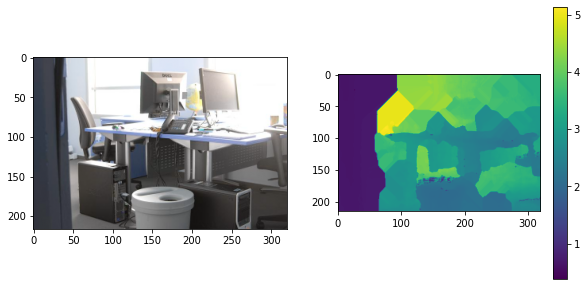

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(exp_aif)
plt.subplot(1, 2, 2)
plt.imshow(exp_dpt)
plt.colorbar()

In [137]:
exp_dpt.shape

(216, 320)

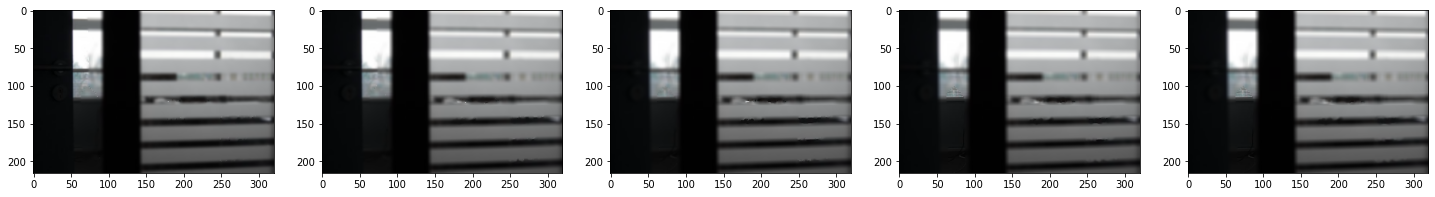

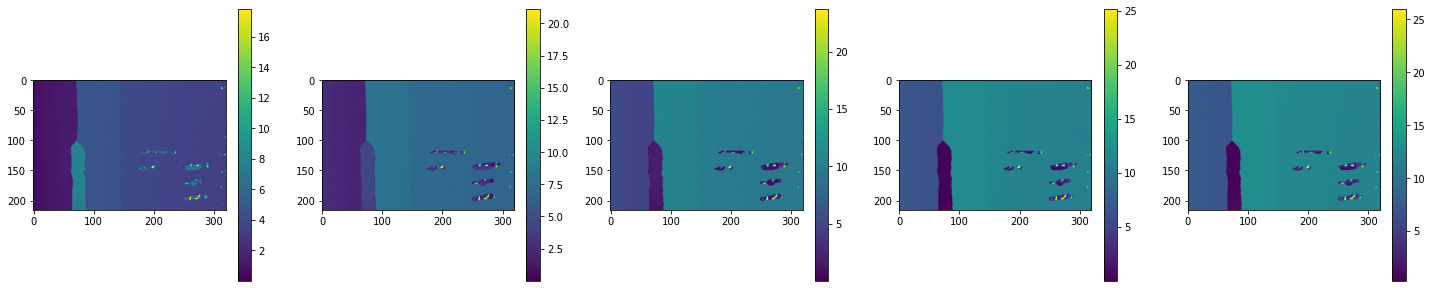

In [138]:
fd_list = [1, 1.5, 2.5, 4, 6]
plt.figure(figsize=(25, 5))
recon_img = []
for i, fd in enumerate(fd_list):
    defocus = camera.getCoC(dpt, fd).type(torch.float32).squeeze(-1)
    fs = render(aif.unsqueeze(0).cuda(), defocus.cuda())
    recon_img.append(fs)
    plt.subplot(1, 5, i+1)
    plt.imshow(fs.cpu().numpy()[0].transpose(1, 2, 0))
    
plt.figure(figsize=(25, 5))
for i, fd in enumerate(fd_list):
    defocus = camera.getCoC(dpt, fd).type(torch.float32)
    exp_defocus = defocus[0].detach().cpu().numpy()
    plt.subplot(1, 5, i+1)
    plt.imshow(exp_defocus)
    plt.colorbar()

In [81]:
recon_loss = BlurMetric('recon')
sharp_loss = BlurMetric('sharp')
ssim_loss = BlurMetric('ssim')
l1_loss = BlurMetric('l1')
mse_loss = BlurMetric('mse')

In [82]:
metric_recon = np.zeros((6, 6))
metric_sharp = np.zeros((6, 6))
metric_ssim = np.zeros((6, 6))
metric_l1 = np.zeros((6, 6))
metric_mse = np.zeros((6, 6))

In [83]:
for i in range(6):
    for j in range(6):
        if i != 5:
            inp = recon_img[i]
        else:
            inp = aif.unsqueeze(0).cuda()
        if j != 5:
            tar = recon_img[j]
        else:
            tar = aif.unsqueeze(0).cuda()
        metric_recon[i, j] = recon_loss(inp, tar).item()
        metric_sharp[i, j] = sharp_loss(inp, tar).item()
        metric_ssim[i, j] = ssim_loss(inp, tar).item()        
        metric_l1[i, j] = l1_loss(inp, tar).item()
        metric_mse[i, j] = l1_loss(inp, tar).item() 

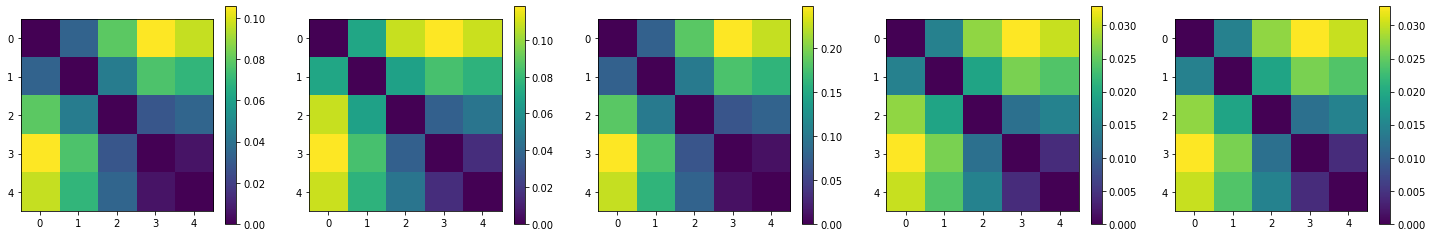

In [84]:
plt.figure(figsize=(25, 4))
for i, n in enumerate([metric_recon, metric_sharp, 1-metric_ssim, metric_l1, metric_mse]):
    plt.subplot(1, 5, i+1)
    plt.imshow(n[:5, :5])
    plt.colorbar()

## Dataset

In [51]:
dataset_config = {
    'root_dir': data_path,
    'shuffle': False,
    'img_num': 5, 
    'visible_img': 5,
    'focus_dist': [1, 1.5, 2.5, 4, 6],
    'recon_all': True,
    'RGBFD':True,
    'AIF': True,
    'DPT': True,
    'near':0.1,
    'far':10.,
    'scale':1
}
BS = 4

In [62]:
train_dl, test_dl,_ = load_data(dataset_config, 'DSLR', BS)

5 out of 5 images per sample are visible for input
Total number of training sample: 81
Total number of validation sample: 29


In [63]:
dl = iter(test_dl)

In [64]:
exp = next(dl)

In [65]:
dpt = exp['dpt']

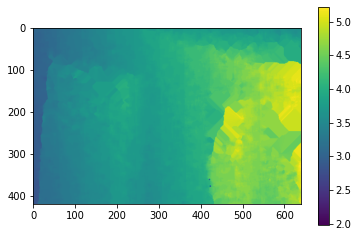

In [66]:
plt.imshow(dpt[0, 0].numpy())
plt.colorbar()

In [61]:
dpt.shape

torch.Size([4, 1, 432, 420])

In [11]:
np.arange(0, 100, 12)[:8]

array([ 0, 12, 24, 36, 48, 60, 72, 84])

In [15]:
n_bin = 100//8

In [16]:
sub_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [21]:
[[i + np.random.randint(0, n_bin)] for i in range(0, 100, n_bin)]

[[7], [23], [32], [36], [54], [62], [79], [88], [103]]

In [12]:
sub_idx = np.arange(100)

In [23]:
84+np.random.randint(0, n_bin)

0